In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d

/home/users/yandanw/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_223/func_0/'

In [3]:
closed_loop_h5_file = os.path.join(func_path, 'visual', '20220806_114038.h5')
f = h5py.File(closed_loop_h5_file, 'r')
start_thetas = f.attrs['start_theta']

In [4]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')
### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
### Unifrom the units and Make then intigers ###
stimulus_start_times = (stimulus_start_times*1000).astype('int') #index needs to be an integers


thetas = np.unique(start_thetas)
theta_categories = {}
for theta in thetas:
    idx = np.where(start_thetas==theta)[0]
    theta_categories[theta] = stimulus_start_times[idx]

loading photodiode data... done


In [5]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

In [6]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))
fixed = brainsss.load_fda_meanbrain()
atlas = brainsss.load_roi_atlas()

explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

def supervoxel_to_full_res(brain, cluster_labels):
    n_clusters = brain.shape[1]
    
    reformed_brain = []
    for z in range(49):
        colored_by_betas = np.zeros((256*128))
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_labels[z,:]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = brain[z,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        reformed_brain.append(colored_by_betas)
    return np.asarray(reformed_brain)

Trying to load timestamp data from hdf5 file.
Success.


In [7]:
bin_start = -2000; bin_end = 5000; bin_size = 200
neural_bins = np.arange(bin_start,bin_end,bin_size)
baseline_idx = 8 #-400ms

In [ ]:
all_explosions = {}
all_warps = {}
STA_brains = {}
for theta in thetas:
    event_times_list = theta_categories[theta]
    
    t0 = time.time()
    STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = event_times_list,
                                       neural_bins = neural_bins)
    print(F'STA {time.time()-t0}')

    reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)
    STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
    STA_brains[theta] = STA_brain
    STA_brain -= STA_brain[:,baseline_idx,np.newaxis,:,:]
    
    
    t0 = time.time()
    warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_223', fixed=fixed, anat_to_mean_type='myr')
    all_warps[theta] = np.asarray(warps)

    print(F'Warps {time.time()-t0}')
    
    explosions = []
    t0 = time.time()
    for tp in range(len(neural_bins)-1):
        input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
        data_to_plot = warps[tp][:,:,::-1]
        vmax = 0.5
        explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                            diverging=True)#'hot')
        explosions.append(explosion_map)
    print(F'Explosion {time.time()-t0}')
    all_explosions[theta] = explosions

STA 0.3153376579284668
Warps 16.037342309951782
Explosion 35.619199991226196
STA 0.40201830863952637
Warps 14.09582257270813
Explosion 35.47992753982544
STA 0.4295322895050049
Warps 13.71888279914856
Explosion 35.53434491157532
STA 0.44304966926574707
Warps 14.207714319229126
Explosion 36.07052993774414
STA 0.4340806007385254
Warps 14.042473554611206
Explosion 36.16141891479492


In [16]:
delta_neural_map = all_warps[50] - all_warps[-50]

In [19]:
all_warps[50].shape

(34, 314, 146, 91)

In [25]:
np.shape(all_explosions[50])

(34, 500, 500, 3)

In [30]:
delta_neural_map.shape

(34, 314, 146, 91)

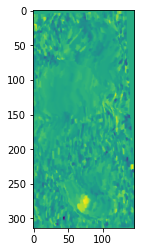

In [33]:
plt.imshow(delta_neural_map[10][:,:,30])

In [36]:
explosions = []
t0 = time.time()
for tp in range(len(neural_bins)-1):
    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = delta_neural_map[tp][:,:,::-1]
    vmax = 0.5
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic',
                                                        diverging=True)#'hot')
    explosions.append(explosion_map)
print(F'Explosion {time.time()-t0}')
all_explosions = explosions

Explosion 26.64434242248535


In [38]:
np.shape(all_explosions)

(34, 500, 500, 3)

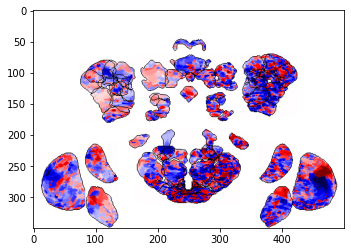

In [43]:
plt.imshow(all_explosions[10][150:,:])

In [51]:
save_path = os.path.join(func_path,'figs','20220923b')
os.mkdir(save_path)

In [48]:
len(neural_bins), len(all_explosions)

(35, 34)

In [52]:
for tp in range(len(neural_bins)-1):
    plt.figure(figsize=(10,5))
    plt.imshow(all_explosions[tp][150:,:])
    plt.title('delta map')
    plt.axis('off')
    
    plt.text(x=800,y=150,s=f'{neural_bins[tp]}ms',fontsize=14)
    save_file = os.path.join(save_path,str(tp).zfill(5))
    plt.savefig(save_file,dpi=300,bbox_inches='tight')
    plt.clf()
    plt.close()